## Read Data

Check if we are running inside interactive environment.
Use `in_ipython` to check if you should make interactive graphics and reports.

In [1]:
in_ipython = True
try:
    get_ipython
except NameError:
    in_ipython = False
import pandas as pd

This file was downloaded from https://www.kaggle.com/wendykan/lending-club-loan-data

File should be put in the `model` folder next to this notebook script.

In [2]:
import os
file_path = 'loan.csv'
if not os.getcwd().endswith('model'):
    file_path = os.path.join('model', file_path)
kaggle_data = pd.read_csv(file_path, low_memory = False)

## Preliminary Transformations (don't need to be run in prediction)

Filter Loans (don't use current loans)

In [3]:
kagge_data = kaggle_data[~kaggle_data.loan_status.isin(["Current", "Does not meet the credit policy. Status:Charged Off",
                                                       "Does not meet the credit policy. Status:Fully Paid", "Issued"])]

Create target variable

In [4]:
kaggle_data = kagge_data.assign(good_loan = pd.Series(kagge_data.loan_status == "Fully Paid"))

## Split Data into Training und Validation Set

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_data, valid_data = train_test_split(kaggle_data,
                                           test_size = 0.25,
                                           random_state = 111)

## Define Target and Features 

In [7]:
target = "good_loan"
cat_features = ['home_ownership', 'purpose', 'addr_state']
num_features = ['loan_amnt', 'installment', 'annual_inc', 'int_rate', 'emp_length']
features = cat_features + num_features

In [8]:
positive_class = True

Data Types

In [9]:
kaggle_data[features].dtypes

home_ownership     object
purpose            object
addr_state         object
loan_amnt         float64
installment       float64
annual_inc        float64
int_rate          float64
emp_length         object
dtype: object

## Define Preprocessing

In [10]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

**Create Derived Features**

In [11]:
import re

In [12]:
def emp_length_num(string):
        if string == '< 1 year':
            emp_length = 0
        else:
            emp_length = find_number(string)
        return emp_length

    
    
def find_number(string):
        if type(string) is float:
            first_number = float('NaN')
        else:
            first_number = int(re.findall(pattern = '(\d+)', string = string)[0])
        return first_number
    
class CreateDerivedFeatures(TransformerMixin, BaseEstimator):
    def __init__(self):
        self

    def fit(self, X, *_):
        return self
        
    def transform(self, X, *_):
        X_transformed = X.assign(loan_income_ratio = pd.Series(X.loan_amnt / X.annual_inc),
                                 interest_income_ratio = pd.Series((X.loan_amnt * 0.01 * X.int_rate)/ X.annual_inc),
                                 emp_length = pd.Series(X.emp_length.apply(emp_length_num)))
       
        return X_transformed


In [13]:
derive_step =('derive', CreateDerivedFeatures())
derive_features = Pipeline([derive_step])

**Categorical Features**

In [14]:
si_step_cat = ('si_cat', SimpleImputer(strategy = 'constant',
                                   fill_value= 'missing_value'))
ohe_step_cat = ('ohe_cat', OneHotEncoder(handle_unknown='ignore',
                                     sparse = False))

pipe_cat = Pipeline([si_step_cat, ohe_step_cat])

**Numerical Features**

In [15]:
si_step_num = ('si_num', SimpleImputer(strategy='constant',
                                       fill_value = -999))
pipe_num = Pipeline([si_step_num])

**Preprocessing**

In [16]:
from sklearn.compose import ColumnTransformer

In [17]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', pipe_cat, cat_features),
        ('num', pipe_num, num_features)
    ])

## Define Classification Model

In [18]:
from sklearn.ensemble import RandomForestClassifier as rf

In [19]:
classifier = rf(n_estimators = 20, max_depth = 20)

## Combine Preprocessing and Classification into Pipeline

In [20]:
preprocessor_classifier = Pipeline([
    ('derive_features', derive_features),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

## Training Modell

In [21]:
fitted_model = preprocessor_classifier.fit(X = train_data[features], y = train_data[target])

## Predictions Modell

In [22]:
train_scores = fitted_model.predict_proba(X = train_data)
train_predictions = fitted_model.predict(X = train_data)
valid_scores = fitted_model.predict_proba(X = valid_data)
valid_predictions = fitted_model.predict(X = valid_data)

## Evaluation Modell

**Classifier with Parameters**

In [23]:
classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
index_positive = np.min(np.where(classifier.classes_ == positive_class))

**Feature Importance**

Here I would like to see the names of the features

In [25]:
top_n_features = 10

In [26]:
importances = fitted_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,top_n_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 74 (0.326842)
2. feature 73 (0.152081)
3. feature 72 (0.143746)
4. feature 71 (0.127597)
5. feature 75 (0.070381)
6. feature 1 (0.011020)
7. feature 5 (0.009580)
8. feature 8 (0.007969)
9. feature 24 (0.006624)
10. feature 7 (0.006531)


In [27]:
if in_ipython:
    import matplotlib.pyplot as plt

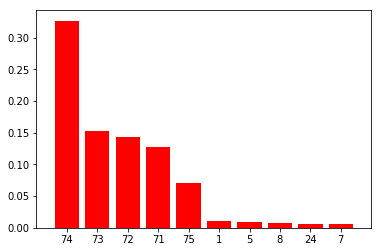

In [28]:
if in_ipython:
    plt.figure()
    plt.bar(range(0,top_n_features), importances[indices][0:top_n_features],
           color="r", align="center")
    plt.xticks(range(0,top_n_features), indices)
    plt.xlim([-1, top_n_features])
    plt.show()

**Classification Report**

In [29]:
from sklearn.metrics import classification_report

Training Set

In [30]:
print(classification_report(y_true= train_data[target],
                      y_pred = train_predictions))

              precision    recall  f1-score   support

       False       0.94      0.17      0.29     50071
        True       0.79      1.00      0.88    155722

   micro avg       0.80      0.80      0.80    205793
   macro avg       0.86      0.58      0.58    205793
weighted avg       0.82      0.80      0.74    205793



Validation Set

In [31]:
print(classification_report(y_true= valid_data[target],
                      y_pred = valid_predictions))

              precision    recall  f1-score   support

       False       0.54      0.06      0.11     16597
        True       0.77      0.98      0.86     52001

   micro avg       0.76      0.76      0.76     68598
   macro avg       0.65      0.52      0.49     68598
weighted avg       0.71      0.76      0.68     68598



**Confusion Matrix**

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
confusion_matrix(y_true = valid_data[target],
                 y_pred = valid_predictions)

array([[ 1064, 15533],
       [  924, 51077]])

**ROC**

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

In [35]:
roc_auc_score(y_true= valid_data[target],
              y_score = valid_scores[:,index_positive])

0.6817337102924188

In [36]:
fpr, tpr, thresholds = roc_curve(y_true= valid_data[target], y_score=valid_scores[:,index_positive])

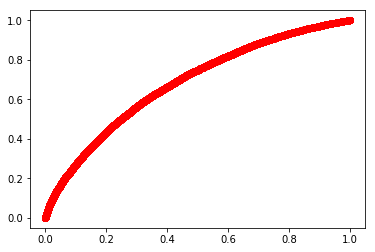

In [37]:
if in_ipython:
    plt.plot(fpr, tpr, 'ro')

**Example Predictions**

In [38]:
valid_data_predictions = valid_data.assign(scores = pd.Series(valid_scores[:,index_positive]).values)

In [39]:
high_predictions = valid_data_predictions[valid_data_predictions.scores > 0.98]

In [40]:
high_predictions.head(20)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_loan,scores
226546,1118570,1356039,4150.0,4150.0,4150.000000,36 months,7.51,129.11,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.989066
217416,1282553,1526329,12000.0,12000.0,12000.000000,36 months,6.03,365.23,A,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.986342
195637,1555814,1822334,9000.0,9000.0,9000.000000,36 months,7.90,281.62,A,A4,...,NaN,NaN,NaN,NaN,9900.0,NaN,NaN,NaN,True,0.980136
345418,21360160,23673067,2000.0,2000.0,2000.000000,36 months,7.69,62.39,A,A4,...,NaN,NaN,NaN,NaN,97500.0,NaN,NaN,NaN,True,0.984842
14953,757895,957991,3000.0,3000.0,3000.000000,36 months,5.42,90.48,A,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.983866
222420,1203743,1444875,8000.0,8000.0,8000.000000,36 months,6.03,243.49,A,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.980396
17869,708178,900645,9000.0,9000.0,8997.458968,36 months,5.79,272.95,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.985979
234426,37167359,39940113,6000.0,6000.0,6000.000000,36 months,6.49,183.87,A,A2,...,NaN,NaN,NaN,NaN,63800.0,NaN,NaN,NaN,True,0.989663
18975,685536,875193,9925.0,9925.0,9925.000000,36 months,7.29,307.78,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.981341
427168,12786153,14808284,6500.0,6500.0,6500.000000,36 months,7.90,203.39,A,A4,...,NaN,NaN,NaN,NaN,24500.0,NaN,NaN,NaN,True,0.981041


In [41]:
low_predictions = valid_data_predictions[valid_data_predictions.scores < 0.3]

In [42]:
low_predictions.head(20)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_loan,scores
430223,12655855,14658007,25000.0,25000.0,25000.0,60 months,24.08,720.37,F,F2,...,NaN,NaN,NaN,NaN,28100.0,NaN,NaN,NaN,False,0.251048
203376,1468419,1725014,9800.0,9800.0,9800.0,60 months,23.76,280.57,F,F4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.290052
168576,3244731,3986882,30225.0,30225.0,30225.0,60 months,23.63,863.04,F,F3,...,NaN,NaN,NaN,NaN,26400.0,NaN,NaN,NaN,False,0.288476
66215,8637948,10409831,18000.0,18000.0,18000.0,60 months,25.80,536.80,G,G1,...,NaN,NaN,NaN,NaN,45700.0,NaN,NaN,NaN,True,0.263589
794796,44805183,47882895,13850.0,13850.0,13850.0,60 months,25.83,413.29,G,G2,...,NaN,NaN,NaN,NaN,20400.0,NaN,NaN,NaN,True,0.293630
171931,3158520,3870925,29175.0,29175.0,29125.0,60 months,23.76,835.25,F,F4,...,NaN,NaN,NaN,NaN,34400.0,NaN,NaN,NaN,True,0.292740
416902,13126174,15148371,18000.0,18000.0,17950.0,60 months,19.99,476.79,E,E1,...,NaN,NaN,NaN,NaN,10500.0,NaN,NaN,NaN,True,0.276427
120827,5785333,7217476,35000.0,35000.0,34975.0,36 months,21.60,1329.44,E,E3,...,NaN,NaN,NaN,NaN,48200.0,NaN,NaN,NaN,True,0.265668
